In [1]:
import torch
import numpy as np
import slayerSNN as snn
from pathlib import Path
import logging
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
output_size = 20
lr = 0.01

data_dir='/home/tasbolat/some_python_examples/data_VT_SNN/'
batch_size=8
sample_file=2
epochs = 500

In [3]:
class ViTacVisDataset(Dataset):
    def __init__(self, path, sample_file, output_size):
        self.path = path
        sample_file = Path(path) / sample_file
        self.samples = np.loadtxt(sample_file).astype("int")
        self.vis = torch.load(Path(path) / "ds_vis.pt")
        self.output_size = output_size

    def __getitem__(self, index):
        input_index = self.samples[index, 0]
        class_label = self.samples[index, 1]
        target_class = torch.zeros((self.output_size, 1, 1, 1))
        target_class[class_label, ...] = 1

        return (
            self.vis[input_index],
            target_class,
            class_label,
        )

    def __len__(self):
        return self.samples.shape[0]

In [4]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 10,
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 325, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 325,
            },
            "tgtSpikeCount": {True: 150, False: 5},
        }
    },
}

In [5]:
class EncoderVis(torch.nn.Module):
    def __init__(self, netParams, output_size):
        super(EncoderVis, self).__init__()
        self.slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.fc1   = self.slayer.dense((50, 63, 2), output_size)
    def forward(self, downsampled):
        spikeLayer1 = self.slayer.spike(self.slayer.psp(downsampled)) # 32, 32, 16
        spikeLayer5 = self.slayer.spike(self.fc1(self.slayer.psp(spikeLayer1))) #  10
        self.spike_trains = [spikeLayer1]
        return spikeLayer5

In [6]:
device = torch.device("cuda:1")

In [7]:
train_dataset = ViTacVisDataset(
    path=data_dir, sample_file=f"train_80_20_{sample_file}.txt", output_size=output_size
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)
test_dataset = ViTacVisDataset(
    path=data_dir, sample_file=f"test_80_20_{sample_file}.txt", output_size=output_size
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

In [11]:
len(train_dataset)/120

2.0

In [11]:
net = EncoderVis(params, output_size).to(device)
error = snn.loss(params).to(device)
optimizer = torch.optim.RMSprop(
    net.parameters(), lr=lr, weight_decay=0.5
)

In [14]:
tr_losses=[]
te_losses=[]
tr_accs=[]
te_accs=[]

for epoch in range(1, epochs+1):
    correct = 0
    num_samples = 0
    batch_loss = 0
    net.train()
    for i, (vis, target, label) in enumerate(train_loader):
        
        vis = vis.to(device)
        
        target = target.to(device)
        output = net.forward(vis)
        
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        loss = error.numSpikes(output, target)
        batch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    tr_losses.append(batch_loss / len(train_loader.dataset) )
    tr_accs.append(correct / len(train_loader.dataset) )
    
    correct = 0
    num_samples = 0
    batch_loss = 0
    net.eval()
    with torch.no_grad():
        for i, (vis, target, label) in enumerate(test_loader):

            vis = vis.to(device)

            target = target.to(device)
            output = net.forward(vis)

            correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            loss = error.numSpikes(output, target)
            batch_loss += loss.item()

    te_losses.append(batch_loss / len(test_loader.dataset) )
    te_accs.append(correct / len(test_loader.dataset) )
    
    if epoch%50 == 0:
        print('Epoch ', epoch, '---------------------------------')
        print('Train, Test acc: ', tr_accs[-1], te_accs[-1])

Epoch  50 ---------------------------------
Train, Test acc:  0.9208333333333333 0.5166666666666667
Epoch  100 ---------------------------------
Train, Test acc:  0.9583333333333334 0.6
Epoch  150 ---------------------------------
Train, Test acc:  0.9583333333333334 0.6
Epoch  200 ---------------------------------
Train, Test acc:  0.9458333333333333 0.5166666666666667
Epoch  250 ---------------------------------
Train, Test acc:  0.9333333333333333 0.5
Epoch  300 ---------------------------------
Train, Test acc:  0.975 0.55
Epoch  350 ---------------------------------
Train, Test acc:  0.9916666666666667 0.5
Epoch  400 ---------------------------------
Train, Test acc:  0.9458333333333333 0.5333333333333333
Epoch  450 ---------------------------------
Train, Test acc:  0.95 0.5666666666666667
Epoch  500 ---------------------------------
Train, Test acc:  0.9833333333333333 0.5833333333333334


In [15]:
torch.save(net.state_dict(), 'vision_model.pt')

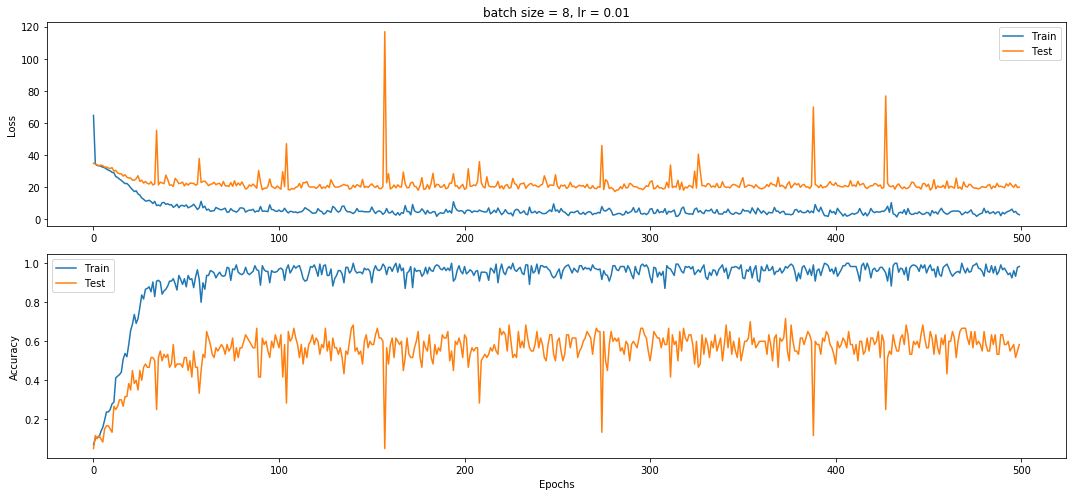

In [16]:
fig, ax = plt.subplots(2, figsize=(15,7))
ax[0].set_title('batch size = ' + str(batch_size) + ', lr = ' + str(lr))
ax[0].plot(tr_losses)
ax[0].plot(te_losses)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Loss')

ax[1].plot(tr_accs)
ax[1].plot(te_accs)
ax[1].legend(['Train', 'Test'])
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
plt.tight_layout()
fig.savefig('results/vis_'+str(batch_size) + '_' + str(lr) +'.png')

plt.show()